In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new Sequential model
new_model = Sequential()

# Add the ResNet50 base model to the new model
new_model.add(base_model)

# Add a new FC layer with softmax activation
new_model.add(Flatten())
new_model.add(Dense(10, activation='softmax'))

# Freeze layers in base_model
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary
new_model.summary()

# Path for training data
TRAIN_PATH = "train"

# Path for validation data
VALID_PATH = "val"

# Path for test data (same as validation for this example)
TEST_PATH = "test"

# Define data generator to preprocess input data and create train, valid, and test generators
batch_size = 8
datagen = image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Create the generator for training data
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the generator for validation data
valid_generator = datagen.flow_from_directory(
    VALID_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the generator for test data
test_generator = datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)

# Define a custom callback to print best validation accuracy and epoch after every epoch
class PrintBestValidationAccuracy(Callback):
    def __init__(self):
        super(PrintBestValidationAccuracy, self).__init__()
        self.best_val_accuracy = -1
        self.best_epoch = -1

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.best_epoch = epoch + 1
        print(f"Best Validation Accuracy: {self.best_val_accuracy:.4f}, Achieved at Epoch: {self.best_epoch}")

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint("modelresnet.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
csv_logger = CSVLogger("epochinforesnet50.csv", separator=',', append=True)
print_best_val_accuracy_callback = PrintBestValidationAccuracy()

# Train the model
history = new_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=200,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, checkpoint, csv_logger, print_best_val_accuracy_callback],
    initial_epoch=0
)

# Load the best model
model = tf.keras.models.load_model('modelresnet.h5')

# Make predictions on test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print and visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │       1,003,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,591,242 (93.81 MB)

 Trainable params: 1,003,530 (3.83 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 14611 images belonging to 8 classes.
Found 3127 images belonging to 8 classes.
Found 3149 images belonging to 8 classes.


C:\Users\rvu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 8), output.shape=(None, 10)

Found 14611 images belonging to 8 classes.
Found 3127 images belonging to 8 classes.
Found 3149 images belonging to 8 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │         802,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,390,536 (93.04 MB)

 Trainable params: 802,824 (3.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7824 - loss: 9.0057
Epoch 1: val_accuracy improved from None to 0.87912, saving model to modelresnet.h5


Best Validation Accuracy: 0.8791, Achieved at Epoch: 1
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 641s 348ms/step - accuracy: 0.8383 - loss: 8.1957 - val_accuracy: 0.8791 - val_loss: 8.3548
Epoch 2/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9426 - loss: 3.2259
Epoch 2: val_accuracy improved from 0.87912 to 0.90086, saving model to modelresnet.h5


Best Validation Accuracy: 0.9009, Achieved at Epoch: 2
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 434s 237ms/step - accuracy: 0.9387 - loss: 3.6705 - val_accuracy: 0.9009 - val_loss: 8.4334
Epoch 3/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9590 - loss: 2.3935
Epoch 3: val_accuracy improved from 0.90086 to 0.91525, saving model to modelresnet.h5


Best Validation Accuracy: 0.9153, Achieved at Epoch: 3
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 435s 238ms/step - accuracy: 0.9571 - loss: 2.7046 - val_accuracy: 0.9153 - val_loss: 7.7246
Epoch 4/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9698 - loss: 1.8157
Epoch 4: val_accuracy did not improve from 0.91525
Best Validation Accuracy: 0.9153, Achieved at Epoch: 3
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 437s 239ms/step - accuracy: 0.9684 - loss: 1.9821 - val_accuracy: 0.9050 - val_loss: 10.6753
Epoch 5/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9752 - loss: 1.4212
Epoch 5: val_accuracy did not improve from 0.91525
Best Validation Accuracy: 0.9153, Achieved at Epoch: 3
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 438s 240ms/step - accuracy: 0.9739 - loss: 1.7043 - val_accuracy: 0.9041 - val_loss: 11.8365
Epoch 6/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9788 - loss: 1.3420
Epoch 6: val_accuracy improved from 0.91525 to 0.91685, saving model to modelresnet.h5


Best Validation Accuracy: 0.9169, Achieved at Epoch: 6
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 448s 245ms/step - accuracy: 0.9781 - loss: 1.5714 - val_accuracy: 0.9169 - val_loss: 10.4580
Epoch 7/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9826 - loss: 1.1150
Epoch 7: val_accuracy improved from 0.91685 to 0.91813, saving model to modelresnet.h5


Best Validation Accuracy: 0.9181, Achieved at Epoch: 7
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 444s 243ms/step - accuracy: 0.9836 - loss: 1.1250 - val_accuracy: 0.9181 - val_loss: 12.0681
Epoch 8/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9827 - loss: 1.1144
Epoch 8: val_accuracy improved from 0.91813 to 0.92101, saving model to modelresnet.h5


Best Validation Accuracy: 0.9210, Achieved at Epoch: 8
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 438s 240ms/step - accuracy: 0.9835 - loss: 1.1576 - val_accuracy: 0.9210 - val_loss: 11.6395
Epoch 9/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9861 - loss: 0.9371
Epoch 9: val_accuracy did not improve from 0.92101
Best Validation Accuracy: 0.9210, Achieved at Epoch: 8
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 433s 237ms/step - accuracy: 0.9857 - loss: 1.0203 - val_accuracy: 0.9089 - val_loss: 17.1534
Epoch 10/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9866 - loss: 0.9016
Epoch 10: val_accuracy did not improve from 0.92101
Best Validation Accuracy: 0.9210, Achieved at Epoch: 8
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 439s 240ms/step - accuracy: 0.9889 - loss: 0.7697 - val_accuracy: 0.9169 - val_loss: 15.1495
Epoch 11/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9906 - loss: 0.6952
Epoch 11: val_accuracy did not improve from 0.92101
Best Validation Accuracy: 0.9210,

Best Validation Accuracy: 0.9274, Achieved at Epoch: 14
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 782s 428ms/step - accuracy: 0.9916 - loss: 0.6137 - val_accuracy: 0.9274 - val_loss: 14.4849
Epoch 15/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9951 - loss: 0.3841
Epoch 15: val_accuracy improved from 0.92741 to 0.92773, saving model to modelresnet.h5


Best Validation Accuracy: 0.9277, Achieved at Epoch: 15
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 782s 428ms/step - accuracy: 0.9934 - loss: 0.5482 - val_accuracy: 0.9277 - val_loss: 15.8964
Epoch 16/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9914 - loss: 0.5751
Epoch 16: val_accuracy did not improve from 0.92773
Best Validation Accuracy: 0.9277, Achieved at Epoch: 15
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 746s 408ms/step - accuracy: 0.9927 - loss: 0.5020 - val_accuracy: 0.9191 - val_loss: 17.7646
Epoch 17/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9920 - loss: 0.6018
Epoch 17: val_accuracy did not improve from 0.92773
Best Validation Accuracy: 0.9277, Achieved at Epoch: 15
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 794s 435ms/step - accuracy: 0.9921 - loss: 0.5594 - val_accuracy: 0.9239 - val_loss: 15.8178
Epoch 18/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9938 - loss: 0.5754
Epoch 18: val_accuracy did not improve from 0.92773
Best Validation Accuracy: 0.

Best Validation Accuracy: 0.9306, Achieved at Epoch: 19
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 457s 250ms/step - accuracy: 0.9943 - loss: 0.4666 - val_accuracy: 0.9306 - val_loss: 16.3196
Epoch 20/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9947 - loss: 0.4041
Epoch 20: val_accuracy did not improve from 0.93060
Best Validation Accuracy: 0.9306, Achieved at Epoch: 19
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 461s 252ms/step - accuracy: 0.9932 - loss: 0.5827 - val_accuracy: 0.9092 - val_loss: 20.0541
Epoch 21/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9957 - loss: 0.3508
Epoch 21: val_accuracy improved from 0.93060 to 0.93316, saving model to modelresnet.h5


Best Validation Accuracy: 0.9332, Achieved at Epoch: 21
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 463s 253ms/step - accuracy: 0.9958 - loss: 0.3291 - val_accuracy: 0.9332 - val_loss: 14.5957
Epoch 22/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9964 - loss: 0.2478
Epoch 22: val_accuracy did not improve from 0.93316
Best Validation Accuracy: 0.9332, Achieved at Epoch: 21
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 464s 254ms/step - accuracy: 0.9957 - loss: 0.2838 - val_accuracy: 0.9245 - val_loss: 17.8735
Epoch 23/200
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9950 - loss: 0.4699
Epoch 23: val_accuracy improved from 0.93316 to 0.93636, saving model to modelresnet.h5


Best Validation Accuracy: 0.9364, Achieved at Epoch: 23
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 460s 252ms/step - accuracy: 0.9955 - loss: 0.4269 - val_accuracy: 0.9364 - val_loss: 16.2556


394/394 ━━━━━━━━━━━━━━━━━━━━ 92s 230ms/step


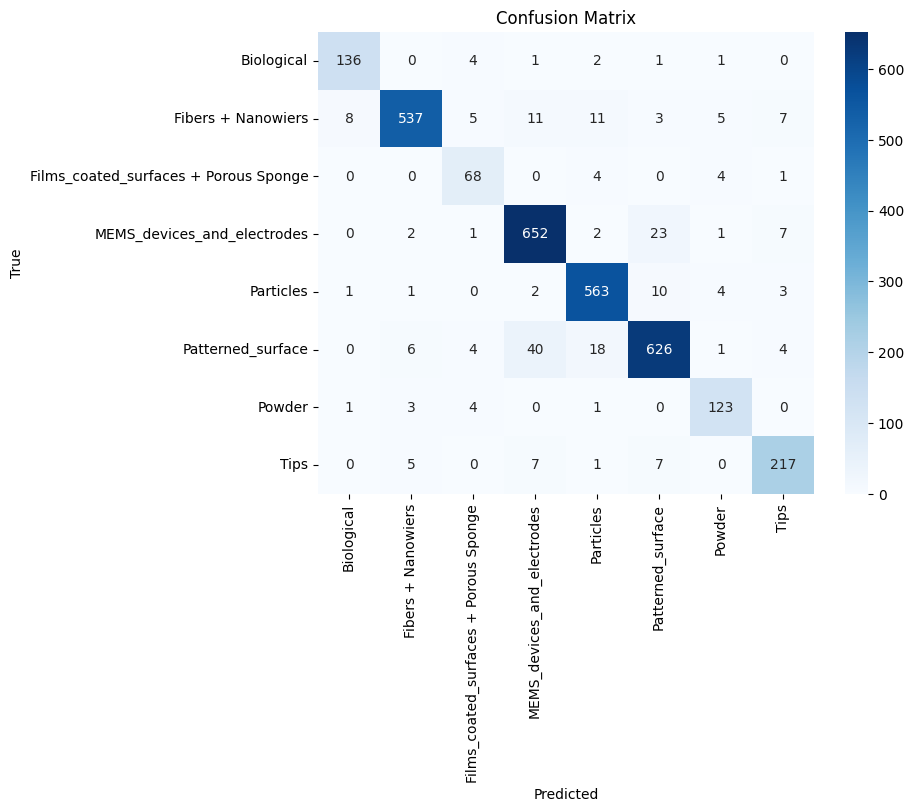

Classification Report:
                                       precision    recall  f1-score   support

                           Biological       0.93      0.94      0.93       145
                   Fibers + Nanowiers       0.97      0.91      0.94       587
Films_coated_surfaces + Porous Sponge       0.79      0.88      0.83        77
          MEMS_devices_and_electrodes       0.91      0.95      0.93       688
                            Particles       0.94      0.96      0.95       584
                    Patterned_surface       0.93      0.90      0.91       699
                               Powder       0.88      0.93      0.91       132
                                 Tips       0.91      0.92      0.91       237

                             accuracy                           0.93      3149
                            macro avg       0.91      0.92      0.92      3149
                         weighted avg       0.93      0.93      0.93      3149



In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths for data
TRAIN_PATH = "train"
VALID_PATH = "val"
TEST_PATH = "test"

batch_size = 8
datagen = image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Generators
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    VALID_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
new_model = Sequential()
new_model.add(base_model)
new_model.add(Flatten())
new_model.add(Dense(train_generator.num_classes, activation='softmax'))          

for layer in base_model.layers[:-1]:
    layer.trainable = False

new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

# Custom callback
class PrintBestValidationAccuracy(Callback):
    def __init__(self):
        super(PrintBestValidationAccuracy, self).__init__()
        self.best_val_accuracy = -1
        self.best_epoch = -1

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.best_epoch = epoch + 1
        print(f"Best Validation Accuracy: {self.best_val_accuracy:.4f}, Achieved at Epoch: {self.best_epoch}")

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint("modelresnet.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
csv_logger = CSVLogger("epochinforesnet50.csv", separator=',', append=True)
print_best_val_accuracy_callback = PrintBestValidationAccuracy()

history = new_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=200,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, checkpoint, csv_logger, print_best_val_accuracy_callback],
    initial_epoch=0
)

model = tf.keras.models.load_model('modelresnet.h5')

# Predict & Evaluate
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)
